# Initialisations

In [1]:
from rwa_functions import *  # custom module for Response-Weighted Analysis

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.fx

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score

import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [2]:
class LocalizationCNN(nn.Module):
    def __init__(self):
        super(LocalizationCNN, self).__init__()
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(15, 16, kernel_size=7, padding=1)
        self.norm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.norm2 = nn.BatchNorm2d(32)
        
        # self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # self.norm3 = nn.BatchNorm2d(128)
        
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        
        # Define regressor
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 6 * 6, 64),  # Adjust the size based on the output from the last pooling layer
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 6)  # Output Layer for x, y, z of target and object
        )

    def forward(self, x):
        # Apply convolutional layers with activations, pooling and normalization
        x1 = self.conv1(x / 255.0)
        x = self.tanh(x1)
        x = self.norm1(self.pool(x))
        x2 = self.conv2(x)
        x = self.tanh(x2)
        x = self.norm2(self.pool(x))
        # x3 = self.conv3(x)
        # x = self.relu(x3)
        # x = self.norm3(self.pool(x))
        
        # Apply regressor
        x = self.regressor(x)
        return x1, x2

In [3]:
# Define the network and the trained model
# visual only - no proprioception; agent learns a policy based on visual input only
net = LocalizationCNN()

# load trained model
model_filename = './cnn_training/localization_cnn32.pt'
net.load_state_dict(torch.load(model_filename, map_location=torch.device('cpu')))

<All keys matched successfully>

# Lab Recording Room

In [33]:
# Experiment settings
batch_num = 100
batch_size = 500
zero_mean = False
layer = 'conv1'
dims = [32, 15] # 64 x 64 noise input, 3 channels

# Get centre locations of receptive field to record activation (arbitrary choice)
net.eval()
X = (torch.rand(batch_size, dims[1], dims[0], dims[0]) - 0.5) * 255 # colored noise pattern ensemble, zero mean
x1, x2 = net(X)
if layer == 'conv1':
    nR,nC = x1[0,0,:,:].shape
elif layer == 'conv2':
    nR,nC = x2[0,0,:,:].shape
print(f'Size of {layer} activation map: ({nR}, {nC})')
locs = [int(round(float(nR)/2.0)), int(round(float(nC)/2.0))] # location of the centre pixel
print(f'r, c centre locations of the receptive fields are ({locs[0]}, {locs[1]})')

# Recording
if layer == 'conv1':
    act_conv1, noise1 = ActRecorder(layer, net, 'fetch', locs, dims, batch_num, batch_size, zero_mean = zero_mean)
    print(f'min, max and mean of noise: {noise1.min(), noise1.max(), noise1.mean()}')
    # Remove biases
    for unit in range(act_conv1.shape[0]):
        act_conv1[unit] -= net.state_dict()['conv1.bias'][unit]
        
elif layer == 'conv2':
    act_conv2, noise2 = ActRecorder(layer, net, 'fetch', locs, dims, batch_num, batch_size, zero_mean = zero_mean)
    print(f'min, max and mean of noise: {noise2.min(), noise2.max(), noise2.mean()}')
    # Remove biases
    for unit in range(act_conv2.shape[0]):
        act_conv2[unit] -= net.state_dict()['conv2.bias'][unit]

Size of conv1 activation map: (28, 28)
r, c centre locations of the receptive fields are (14, 14)


100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Activation recording complete.


100%|██████████| 16/16 [00:00<00:00, 83.34it/s]


Shape of activation response list: torch.Size([16, 50000])
Shape of noise list: torch.Size([50000, 32, 32, 15])
min, max and mean of noise: (tensor(0.), tensor(255.), tensor(127.5010))


Save the input and output

In [5]:
path_dict = {True: '_0mean', False:'', 'conv1': 1, 'conv2': 2}

In [34]:
# Conv1
layer = 'conv1'
torch.save(act_conv1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
torch.save(noise1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

In [ ]:
# Conv2
layer = 'conv2'
torch.save(act_conv2, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
torch.save(noise2, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

# Conv1 - Zero Mean [-127.5, 127,5]

In [67]:
# load existing data if already recorded
path_dict = {True: '_0mean', False:'', 'conv1': 1, 'conv2': 2}

batch_num = 100
batch_size = 500
zero_mean = True
layer = 'conv1'

# intput & output
act_conv1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
noise1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

# RWA for RF
rf1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')
rf_corr1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/rf_corr{path_dict[layer]}.pt')

# RF cropping
correlation1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/correlation{path_dict[layer]}.pt')
# mi1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/mi{path_dict[layer]}.pt')
rf_cropped1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/rf_cropped{path_dict[layer]}.pt')
noise_cropped1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

# RWC
cov1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

# load eigen1.pkl
with open(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'rb') as f:
    eigen1 = pickle.load(f)

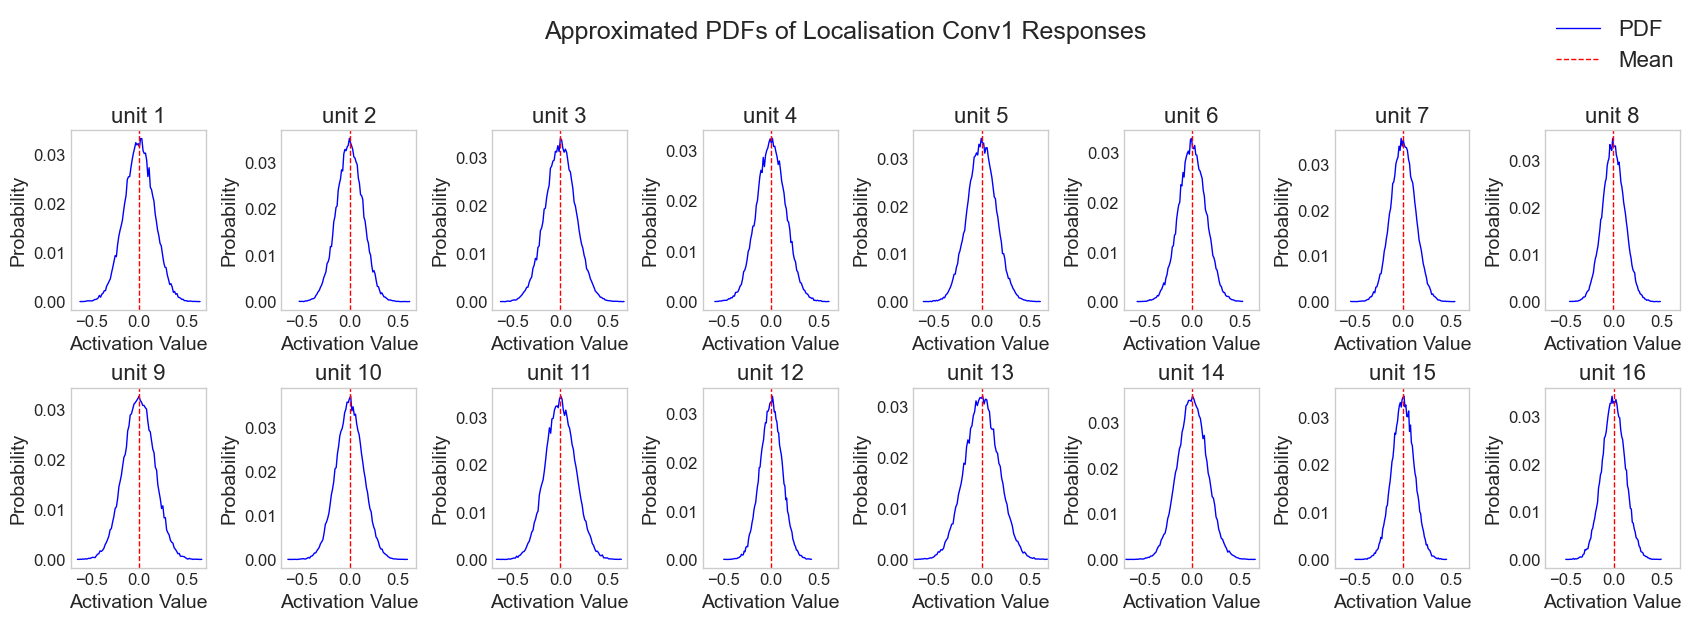

In [40]:
# PDFs of conv1 responses
# gaussian shape is a result of convolution
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(act_conv1.shape[0]):
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf, color='blue', linewidth=1)
        plt.xlabel('Activation Value', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
        plt.title('unit ' + str(i+1), fontsize=16)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=16)
        plt.axis('off')
    plt.gcf().set_size_inches(14, 9)
    
    # turn off gird
    plt.grid(False)
    # set xtick and ytick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.suptitle('Approximated PDFs of Localisation Conv1 Responses', fontsize=18)

# add a legend
plt.figlegend(['PDF', 'Mean'], loc='upper right', fontsize=16)

# add a boundary box to the legend
# change figure size
plt.gcf().set_size_inches(17, 11)
plt.tight_layout()

# add space below the title
plt.subplots_adjust(top=0.88)
plt.show()

Receptive Field Estimation via Response-Weighted Average

In [8]:
# RWA - unbiased RF estimation, absolute false
rf1 = RWA(act_conv1, noise1, absolute=False)
print(rf1.shape)

100%|██████████| 800000/800000 [00:17<00:00, 44527.39it/s]

Shape of receptive field list: torch.Size([16, 32, 32, 15])
torch.Size([16, 32, 32, 15])


In [9]:
# Save the RWA data
torch.save(rf1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')
# torch.save(rf_abs1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf_abs{path_dict[layer]}.pt')

-1.208 0.968


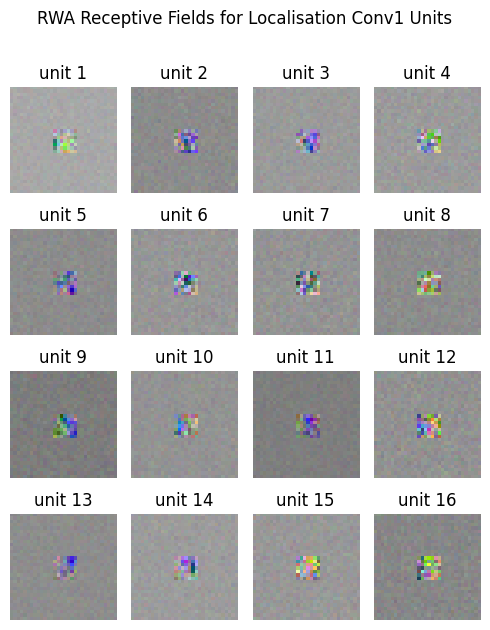

In [14]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i, :, :, 12:]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'RWA Receptive Fields for Localisation Conv1 Units', fontsize=12)
print(np.round(float(rf1.min()), 3), np.round(float(rf1.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Receptive Field Estimation via Pearson Correlation

In [15]:
# Absolute = false - gets the correlation between the RF and the noise for each unit
rf_corr1 = torch.zeros(rf1.shape)
for i in range(rf1.shape[3]): # loop through each channel
    rf_corr1[:, :, :, i] = CorrRWA(act_conv1, noise1[:, :, :, i])

100%|██████████| 16384/16384 [00:27<00:00, 590.58it/s]


In [16]:
# Save the RWA data
torch.save(rf_corr1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/rf_corr{path_dict[layer]}.pt')

-0.184 0.147


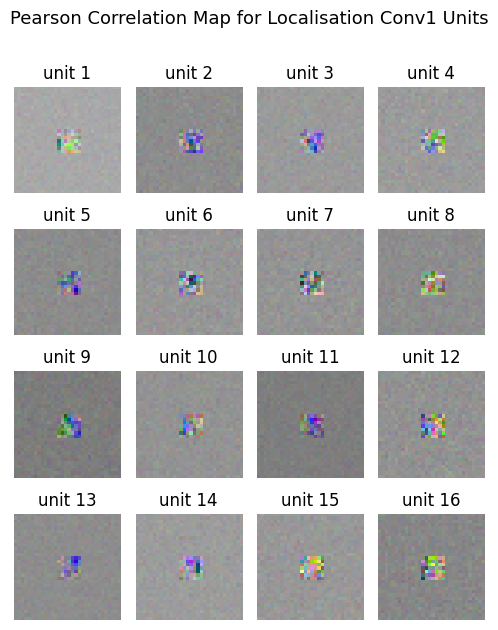

In [17]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr1[i, :, :, 12:]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Pearson Correlation Map for Localisation Conv1 Units', fontsize=13)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

RF Cropping via Pearson Correlation Mask

In [18]:
# calculate the Pearson correlation between the RFs and the input noise and accumulate to obtain mask for cropping
correlation1 = torch.zeros(rf1.shape[1], rf1.shape[2], rf1.shape[3])
for i in range(rf1.shape[3]):
    correlation1[:, :, i] = CorrMask(noise1[:, :, :, i], act_conv1)

100%|██████████| 16384/16384 [00:25<00:00, 638.33it/s]


In [19]:
# save the correlation data
torch.save(correlation1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/correlation{path_dict[layer]}.pt')

In [20]:
# crop the RFs
# Threshold for cropping automatically set at 0.01

# Absolute = false
rf_cropped1 = []
for i in range(rf1.shape[3]): # loop through each channel
    tmp, mask = RfCrop(correlation1[:, :, i], rf1[:, :, :, i]) # crop the RFs
    rf_cropped1.append(tmp)
rf_cropped1 = torch.stack(rf_cropped1, dim=3)

-0.184 0.147


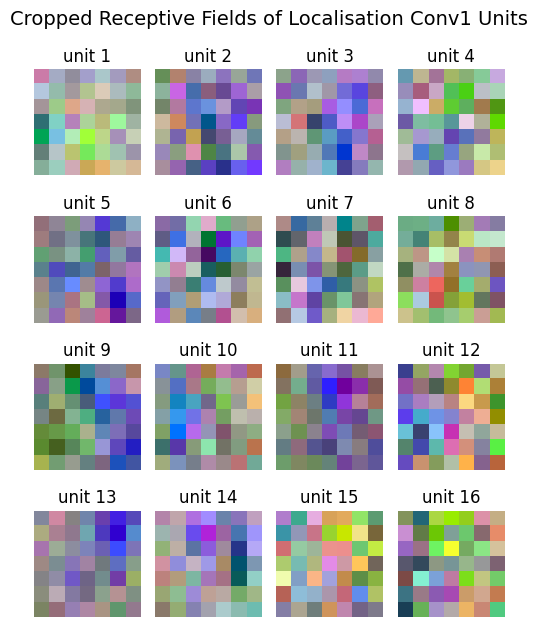

In [21]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped1[i, :, :, 12:]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'Cropped Receptive Fields of Localisation Conv1 Units', fontsize=14)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

In [22]:
# save the cropped RFs
torch.save(rf_cropped1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/rf_cropped{path_dict[layer]}.pt')

Mutual Information

In [ ]:
num_units = act_conv1.shape[0]
mi1 = torch.zeros((num_units, noise1.shape[1], noise1.shape[2], noise1.shape[3])) # single channel

with tqdm(total = num_units * noise1.shape[1] * noise1.shape[2]) as pbar:
    for i in range(num_units):
        for j in range(noise1.shape[1]):
            for k in range(noise1.shape[2]): # go through each pixel
                for l in range(noise1.shape[3]):
                    mi1[i, j, k, l] = mutual_info_score(noise1[:, j, k, l].flatten(), act_conv1[i].flatten())
                    pbar.update(1)

In [ ]:
# save the cropped RFs
torch.save(mi1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/mi{path_dict[layer]}.pt')

In [ ]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = mi1[i, :, :, 12:]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'MI Scores of Fetch Conv1 Units', fontsize=14)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

In [ ]:
# crop the RFs
# Threshold for cropping automatically set at 0.01

# Absolute = false
mi_cropped1 = []
for i in range(rf1.shape[3]): # loop through each channel
    tmp, mask = RfCrop(correlation1[:, :, i], mi1[:, :, :, i]) # crop the RFs
    mi_cropped1.append(tmp)
mi_cropped1 = torch.stack(mi_cropped1, dim=3)

In [ ]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = mi_cropped1[i, :, :, 12:]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], rf1.shape[3])))
    plt.title(f'unit {str(i+1)}', fontsize=14)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'Cropped MI Maps for Localisation Conv1 Units', fontsize=15)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

Response-Weighted Covariance - Normal RWA

In [38]:
# crop noise to the same dimensions as the cropped RFs
noise_cropped1 = torch.zeros(noise1.shape[0], rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
for i in range(noise_cropped1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], noise1[:, :, :, i])
    noise_cropped1[:, :, :, i] = tmp
print(noise_cropped1.shape)

torch.Size([50000, 7, 7, 15])


In [39]:
torch.save(noise_cropped1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

In [24]:
# unravel noise and RFs for RWC + create input for RWC
noise_cropped_flat1 = noise_cropped1.view(noise_cropped1.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat1 = rf_cropped1.view(rf_cropped1.shape[0], -1) # 16, 8*8*3=192

# reformat magnitudes of rf data to fit with noise
if zero_mean:
    rf = ((rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) - 0.5) * 255 # normalise to [-127.5, 127.5]
else:
    rf = (rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) * 255 # normalise to [0, 255]
    
# compute input data for RWC
# mu = noise - rf
mu = torch.zeros(rf_cropped_flat1.shape[0], noise_cropped_flat1.shape[0], noise_cropped_flat1.shape[1])
for i in range(mu.shape[0]):
    mu[i] = noise_cropped_flat1 - rf[i]

# RWC
cov1 = RWC(act_conv1, mu)

100%|██████████| 800000/800000 [04:08<00:00, 3225.33it/s]


In [25]:
print(f"Shape of mu: {mu.shape}")
print(f"Shape of cov1: {cov1.shape}")

Shape of mu: torch.Size([16, 50000, 735])
Shape of cov1: torch.Size([16, 735, 735])


In [26]:
# save the pca covariance data
torch.save(cov1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

In [69]:
# Principal Component Analysis
eigenvalues1 = torch.zeros(cov1.shape[0], cov1.shape[1])
eigenvectors1 = torch.zeros((cov1.shape[0], cov1.shape[1], cov1.shape[1])) # store the PCA components

# Get relevant results
for i in range(cov1.shape[0]): # loop through each unit
    eigen = np.linalg.eigh(cov1[i])
    eigenvectors1[i] = torch.tensor(eigen.eigenvectors)
    eigenvalues1[i] = torch.tensor(eigen.eigenvalues)

In [28]:
# Store the eigenvalues and eigenvectors
eigen1 = (eigenvectors1, eigenvalues1)
with open(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'wb') as f:
    pickle.dump(eigen1, f)

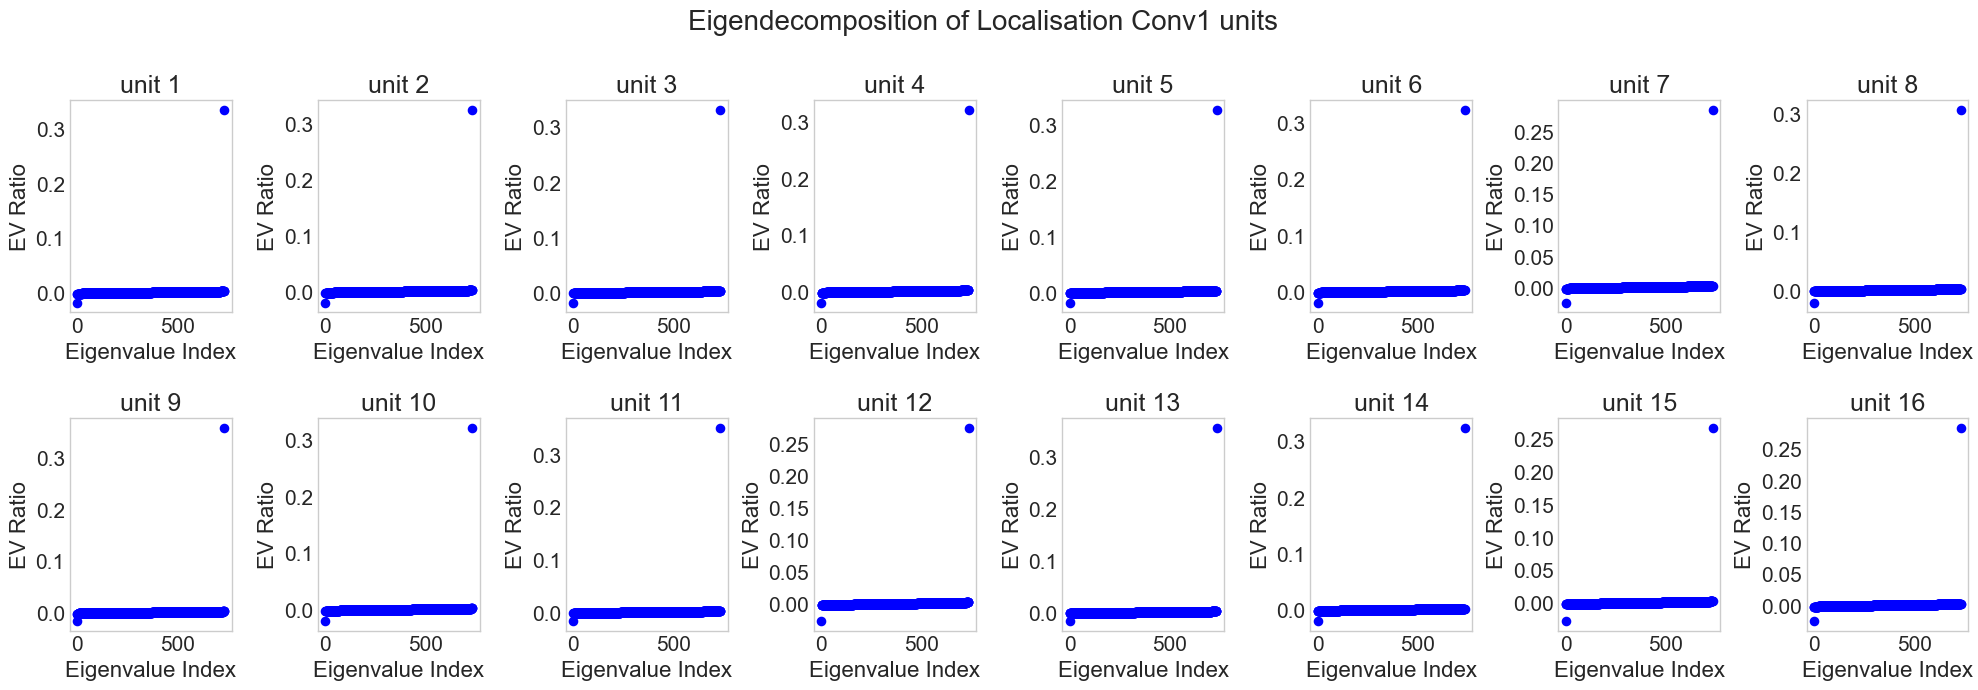

In [70]:
# visualise the eigenvalues
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    y = eigenvalues1[i]
    # reverse the order of the eigenvalues
    y = -1*y.flip(0)
    y /= abs(y).sum()
    plt.scatter(range(len(eigenvalues1[i])), y, s=35, c='blue')
    plt.xlabel('Eigenvalue Index', fontsize=16)
    plt.ylabel('EV Ratio', fontsize=16)
    plt.title('unit ' + str(i+1), fontsize=18)
    plt.gcf().set_size_inches(13, 5)
    # change axis font size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(False)
    
plt.suptitle('Eigendecomposition of Localisation Conv1 units', fontsize=20) 
plt.gcf().set_size_inches(20, 7)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
# add vertical space between subplots
plt.subplots_adjust(hspace=0.5)
plt.show()

-0.184 0.147


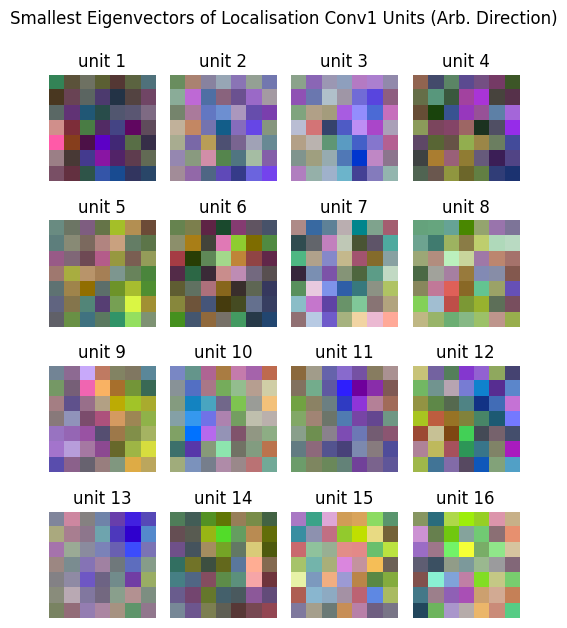

In [31]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors1[i, :, 0].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show[:, :, 12:])
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
# title for the entire plot
plt.suptitle(f'Largest Eigenvectors of Localisation Conv1 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

-0.184 0.147


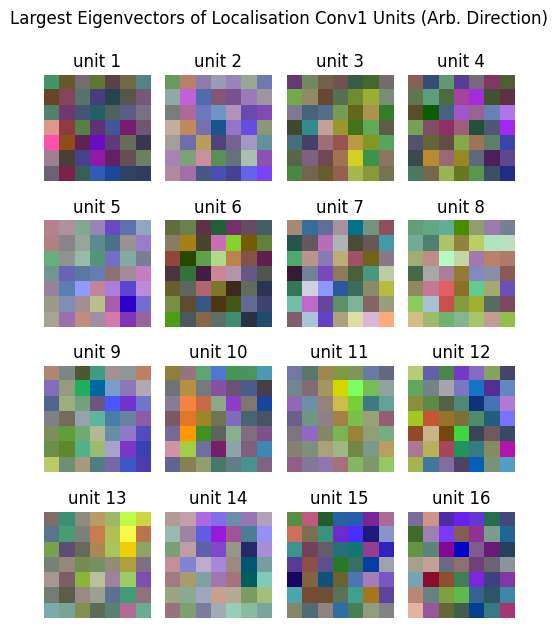

In [32]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors1[i, :, -1].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show[:, :, 12:])
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
# title for the entire plot
plt.suptitle(f'Smallest Eigenvectors of Localisation Conv1 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Conv1 - Positive Only [0, 255]

In [79]:
# load existing data if already recorded
path_dict = {True: '_0mean', False:'', 'conv1': 1, 'conv2': 2}

batch_num = 100
batch_size = 500
zero_mean = False
layer = 'conv1'

# intput & output
act_conv1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/act{path_dict[layer]}.pt')
noise1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/noise{path_dict[layer]}.pt')

# RWA for RF
rf1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')
rf_corr1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/rf_corr{path_dict[layer]}.pt')

# RF cropping
# correlation1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/correlation{path_dict[layer]}.pt')
# mi1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/mi{path_dict[layer]}.pt')
rf_cropped1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/rf_cropped{path_dict[layer]}.pt')
noise_cropped1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

# RWC
cov1 = torch.load(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

# load eigen1.pkl
with open(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'rb') as f:
    eigen1 = pickle.load(f)

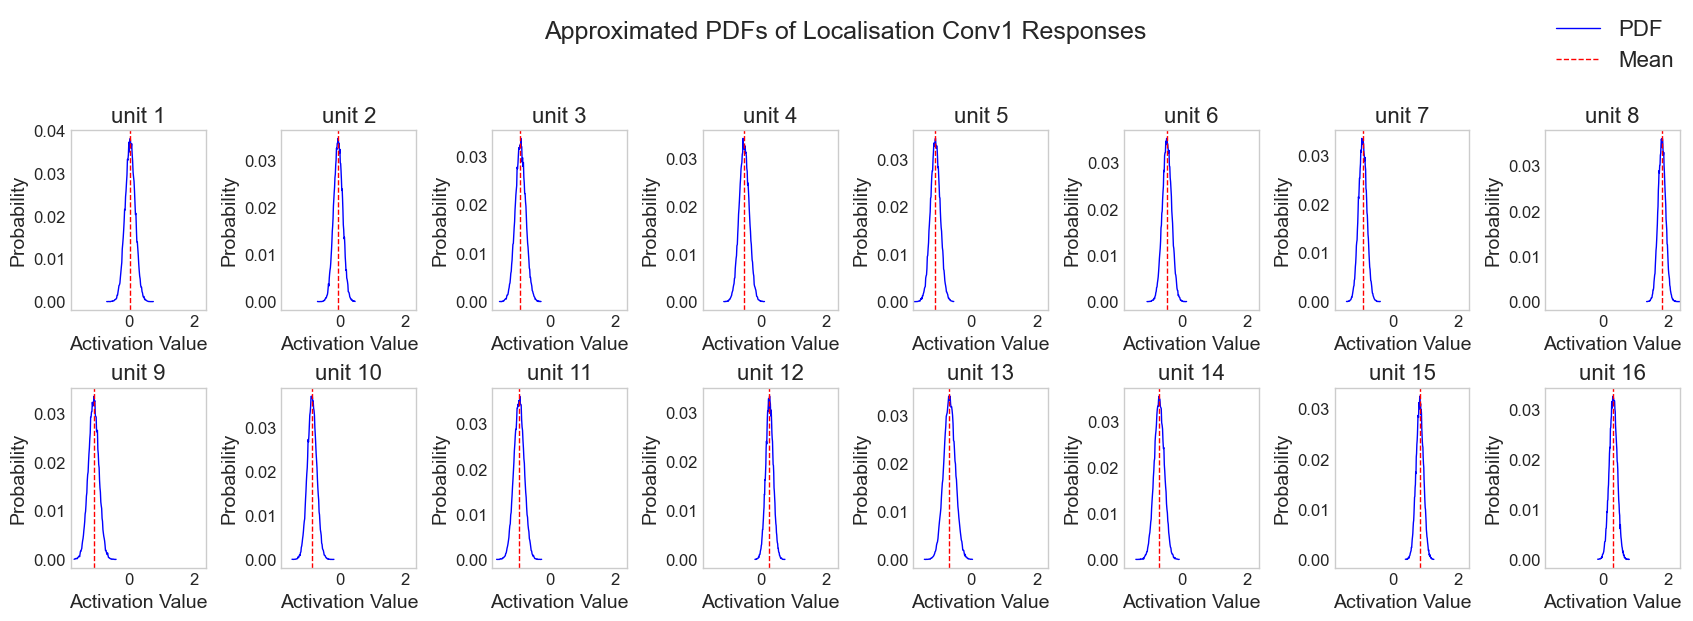

In [80]:
# PDFs of conv1 responses
# gaussian shape is a result of convolution
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(act_conv1.shape[0]):
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf, color='blue', linewidth=1)
        plt.xlabel('Activation Value', fontsize=14)
        plt.ylabel('Probability', fontsize=14)
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
        plt.title('unit ' + str(i+1), fontsize=16)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=16)
        plt.axis('off')
    plt.gcf().set_size_inches(14, 9)
    
    # turn off gird
    plt.grid(False)
    # set xtick and ytick size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.suptitle('Approximated PDFs of Localisation Conv1 Responses', fontsize=18)

# add a legend
plt.figlegend(['PDF', 'Mean'], loc='upper right', fontsize=16)

# add a boundary box to the legend
# change figure size
plt.gcf().set_size_inches(17, 11)
plt.tight_layout()

# add space below the title
plt.subplots_adjust(top=0.88)
plt.show()

RWA

In [43]:
# RWA - unbiased RF estimation
rf1 = RWA(act_conv1, noise1, absolute=False)

100%|██████████| 800000/800000 [00:19<00:00, 41473.82it/s]

Shape of receptive field list: torch.Size([16, 32, 32, 15])


In [44]:
# Save the RWA data
torch.save(rf1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/rf{path_dict[layer]}.pt')
# torch.save(rf_abs1, f'./rwa_data/jaco/jaco_rand{path_dict[zero_mean]}/rf_abs{path_dict[layer]}.pt')

-142.194 230.045


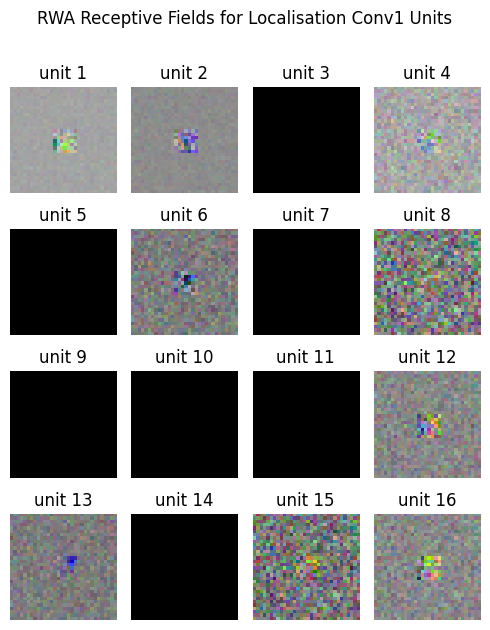

In [82]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i, :, :, 12:]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], 3)))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'RWA Receptive Fields for Localisation Conv1 Units', fontsize=12)
print(np.round(float(rf1.min()), 3), np.round(float(rf1.max()), 3))
# increase the spacing between subplots
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

Receptive Field Estimation via Pearson Correlation

In [48]:
# gets the correlation between the RF and the noise for each unit
rf_corr1 = torch.zeros(rf1.shape)
for i in range(rf1.shape[3]): # loop through each channel
    rf_corr1[:, :, :, i] = CorrRWA(act_conv1, noise1[:, :, :, i])

100%|██████████| 16384/16384 [00:29<00:00, 552.23it/s]


In [49]:
# Save the RWA data
torch.save(rf_corr1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/rf_corr{path_dict[layer]}.pt')

-0.172 0.146


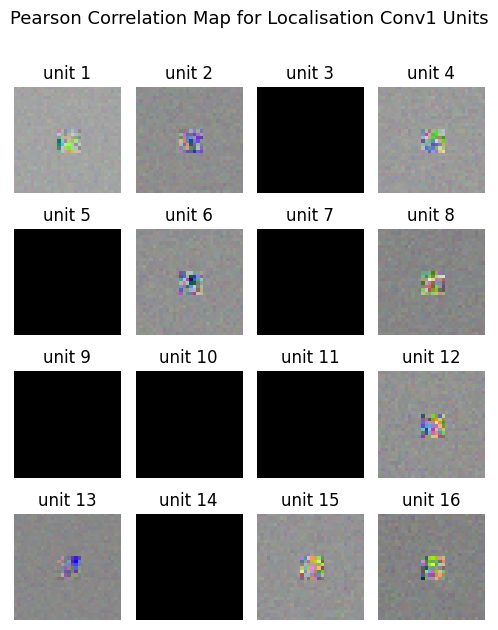

In [83]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_corr1[i, :, :, 12:]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], 3)))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(7, 7)
    
# title for the entire plot
plt.suptitle(f'Pearson Correlation Map for Localisation Conv1 Units', fontsize=13)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

RF Cropping via Pearson Correlation Mask

In [52]:
# crop the RFs
# Threshold for cropping automatically set at 0.01

# Absolute = false
rf_cropped1 = []
for i in range(rf1.shape[3]): # loop through each channel
    tmp, _ = RfCrop(correlation1[:, :, i], rf_corr1[:, :, :, i]) # crop the RFs
    rf_cropped1.append(tmp)
rf_cropped1 = torch.stack(rf_cropped1, dim=3)

In [53]:
# save the cropped RFs
torch.save(rf_cropped1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/rf_cropped{path_dict[layer]}.pt')

-0.172 0.146


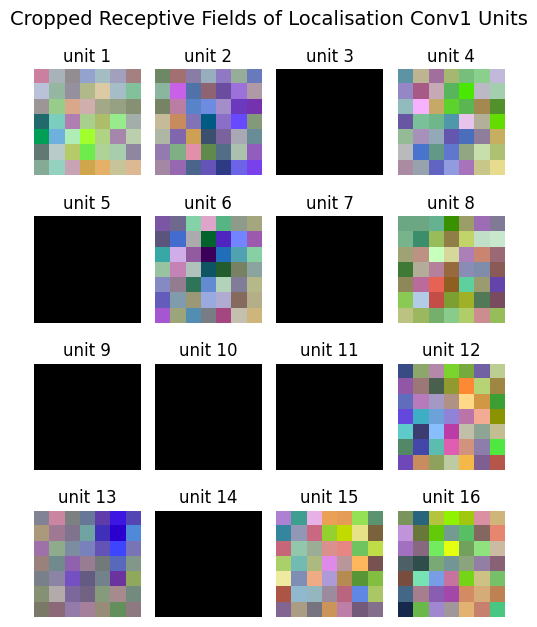

In [84]:
# Absolute = False - Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf_cropped1[i, :, :, 12:]
    
    # if the unit is not dead (positive activation values)
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0: # negative activation values are dead units
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((rf1.shape[1], rf1.shape[2], 3)))
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
    
# title for the entire plot
plt.suptitle(f'Cropped Receptive Fields of Localisation Conv1 Units', fontsize=14)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.show()

Response-Weighted Covariance

In [56]:
# crop noise to the same dimensions as the cropped RFs
noise_cropped1 = torch.zeros(noise1.shape[0], rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
for i in range(noise_cropped1.shape[3]):
    tmp, _ = RfCrop(correlation1[:, :, i], noise1[:, :, :, i])
    noise_cropped1[:, :, :, i] = tmp
print(noise_cropped1.shape)

torch.Size([50000, 7, 7, 15])


In [57]:
torch.save(noise_cropped1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/noise_cropped{path_dict[layer]}.pt')

In [58]:
# unravel noise and RFs for RWC + create input for RWC
noise_cropped_flat1 = noise_cropped1.view(noise_cropped1.shape[0], -1) # 50000, 8*8*3=192
rf_cropped_flat1 = rf_cropped1.view(rf_cropped1.shape[0], -1) # 16, 8*8*3=192

# reformat magnitudes of rf data to fit with noise
if zero_mean:
    rf = ((rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) - 0.5) * 255 # normalise to [-127.5, 127.5]
else:
    rf = (rf_cropped_flat1 - rf_cropped_flat1.min()) / (rf_cropped_flat1.max() - rf_cropped_flat1.min()) * 255 # normalise to [0, 255]
    
# compute input data for RWC
# mu = noise - rf
mu = torch.zeros(rf_cropped_flat1.shape[0], noise_cropped_flat1.shape[0], noise_cropped_flat1.shape[1])
for i in range(mu.shape[0]):
    mu[i] = noise_cropped_flat1 - rf[i]

# RWC
cov1 = RWC(act_conv1, mu)

100%|██████████| 800000/800000 [04:09<00:00, 3208.92it/s]


In [59]:
print(f"Shape of mu: {mu.shape}")
print(f"Shape of cov1: {cov1.shape}")

Shape of mu: torch.Size([16, 50000, 735])
Shape of cov1: torch.Size([16, 735, 735])


In [60]:
# save the pca covariance data
torch.save(cov1, f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/cov{path_dict[layer]}.pt')

In [85]:
# Principal Component Analysis
eigenvalues1 = torch.zeros(cov1.shape[0], cov1.shape[1])
eigenvectors1 = torch.zeros((cov1.shape[0], cov1.shape[1], cov1.shape[1])) # store the PCA components

# Get relevant results
for i in range(cov1.shape[0]): # loop through each unit
    eigen = np.linalg.eigh(cov1[i])
    eigenvectors1[i] = torch.tensor(eigen.eigenvectors)
    eigenvalues1[i] = torch.tensor(eigen.eigenvalues)

In [62]:
# Store the eigenvalues and eigenvectors
eigen1 = (eigenvectors1, eigenvalues1)
with open(f'./rwa_data/fetch/fetch_rand{path_dict[zero_mean]}/eigen{path_dict[layer]}.pkl', 'wb') as f:
    pickle.dump(eigen1, f)

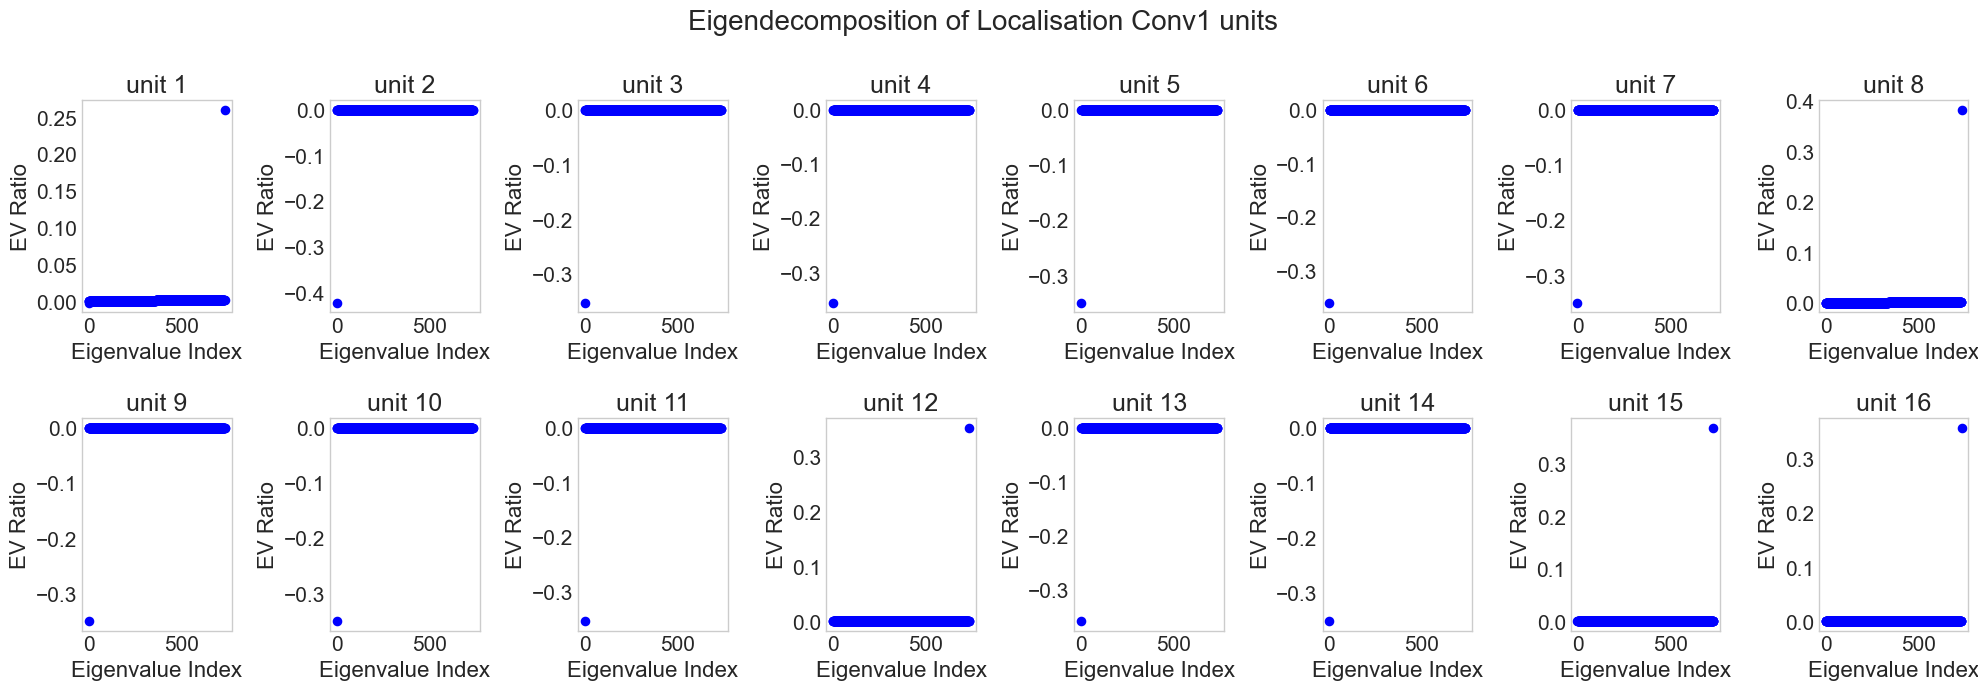

In [86]:
# visualise the eigenvalues
plt.style.use('seaborn-v0_8-whitegrid')
for i in range(cov1.shape[0]):
    plt.subplot(2, 8, i+1)
    y = eigenvalues1[i]
    # reverse the order of the eigenvalues
    # y = -1*y.flip(0)
    y /= abs(y).sum()
    plt.scatter(range(len(eigenvalues1[i])), y, s=35, c='blue')
    plt.xlabel('Eigenvalue Index', fontsize=16)
    plt.ylabel('EV Ratio', fontsize=16)
    plt.title('unit ' + str(i+1), fontsize=18)
    plt.gcf().set_size_inches(13, 5)
    # change axis font size
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(False)
    
plt.suptitle('Eigendecomposition of Localisation Conv1 units', fontsize=20) 
plt.gcf().set_size_inches(20, 7)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
# add vertical space between subplots
plt.subplots_adjust(hspace=0.5)
plt.show()

-0.172 0.146


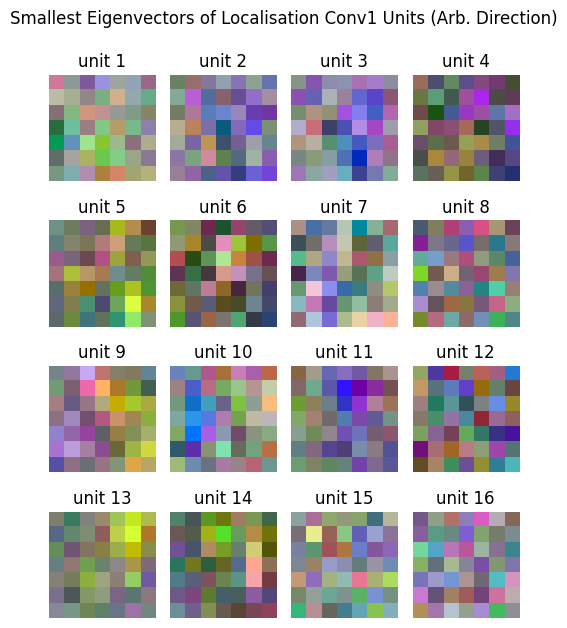

In [87]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors1[i, :, 0].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show[:, :, 12:])
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
# title for the entire plot
plt.suptitle(f'Smallest Eigenvectors of Localisation Conv1 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

-0.172 0.146


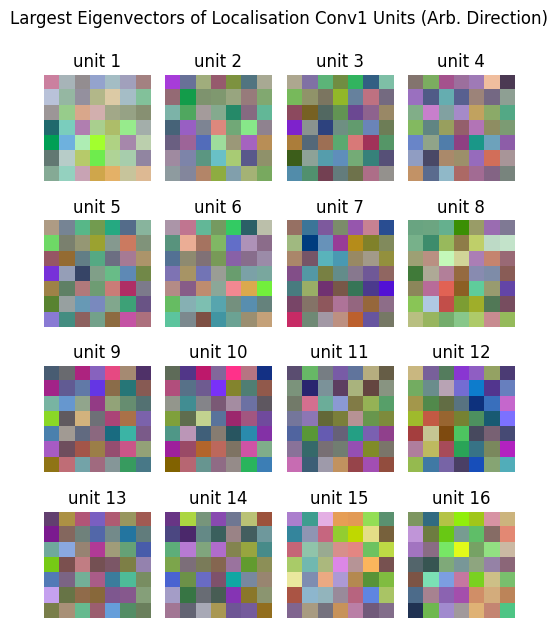

In [88]:
# Absolute = False - Visualise the RWA output as image plots
plt.style.use('default')
for i in range(rf1.shape[0]):
    plt.subplot(4, 4, i+1) # nrows, ncols, index
    plt.axis('off')
    x = eigenvectors1[i, :, -1].reshape(rf_cropped1.shape[1], rf_cropped1.shape[2], rf_cropped1.shape[3])
    to_show = (x - x.min()) / (x.max() - x.min())
    plt.imshow(to_show[:, :, 12:])
    plt.title(f'unit {str(i+1)}', fontsize=12)
    plt.gcf().set_size_inches(6, 6)
# title for the entire plot
plt.suptitle(f'Largest Eigenvectors of Localisation Conv1 Units (Arb. Direction)', fontsize=12)
print(np.round(float(rf_corr1.min()), 3), np.round(float(rf_corr1.max()), 3))
# change figure size
plt.gcf().set_size_inches(5, 6.5)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Conv2 - Zero Mean [-127.5, 127,5]